In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from collections import deque
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

start = datetime.datetime(2012,1,1)
end = datetime.datetime(2022,1,1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df

In [ ]:
def Stock_Price_LSTM_Data_Precesing(df,mem_his_days,pre_days):
    df.dropna(inplace=True)
    df.sort_index(inplace=True)

    df['label'] = df['Close'].shift(-pre_days)

    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:,:-1])

    deq = deque(maxlen=mem_his_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    X = X[:-pre_days]

    y = df['label'].values[mem_his_days-1:-pre_days]

    X = np.array(X)
    y = np.array(y)

    return X,y,X_lately

In [ ]:
X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,5,10)
print(len(X))
print(len(y))
print(len(X_lately))

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from sklearn.model_selection import train_test_split

In [ ]:
X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,5,10)
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)

In [ ]:
pre_days = 10
mem_days = [5,10,15]
lstm_layers = [1,2,3]
dense_layers = [1,2,3]
units = [16,32]

for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = './models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape',
                    mode='min',
                    save_best_only=True)

                X,y,X_lately = Stock_Price_LSTM_Data_Precesing(df,the_mem_days,pre_days)
                X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                
                model = Sequential()
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                model.add(Dropout(0.1))
                
                for i in range(the_lstm_layers):
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0.1))

                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0.1))

                for i in range(the_dense_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0.1))

                model.add(Dense(1))

                model.compile(optimizer='adam',
                             loss='mse',
                             metrics=['mape'])

                model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[checkpoint])

In [47]:
from tensorflow.keras.models import load_model
best_model = load_model('./models/3.01_37_men_5_lstm_2_dense_2_unit_32')
best_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 32)             4864      
                                                                 
 dropout_46 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_31 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_47 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_32 (LSTM)              (None, 5, 32)             8320      
                                                                 
 dropout_48 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_33 (LSTM)              (None, 32)               

In [48]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)
print(len(pre))

8/8 [==============================] - 1s 8ms/step
251


In [ ]:
model.evaluate(X_test,y_test)

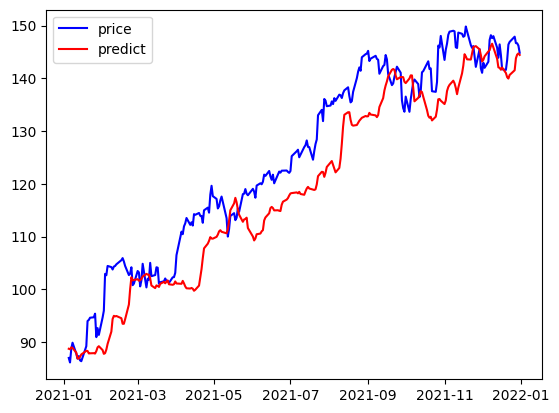

In [49]:
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='blue',label='price')
plt.plot(df_time,pre,color='red',label='predict')
plt.legend()
plt.show()